# D_dt and H_0 Posterior Analysis

Load posterior samples from a completed Alpaca pipeline run and:
1. Plot the **D_dt** posterior distribution
2. Convert each D_dt sample to **H_0** using `Ddt_2_H0`
3. Plot the **H_0** posterior distribution with summary statistics

In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

# Add the project root so alpaca is importable
sys.path.insert(0, os.path.abspath(".."))

from alpaca.utils.cosmology import Ddt_2_H0

## User Settings

Edit the three cells below to match your lens system and run directory.

In [3]:
# ============================================================
# Path to the pipeline output directory (the run_YYYY-MM-DD_HH-MM folder)
# ============================================================
RUN_DIR = "../results/run_2026-01-27_17-02/"  # <-- EDIT THIS

In [4]:
# ============================================================
# Lens system redshifts (required for D_dt -> H_0 conversion)
# ============================================================
Z_LENS   = 0.529      # <-- EDIT: redshift of the lens galaxy
Z_SOURCE = 2.810      # <-- EDIT: redshift of the background source

In [5]:
# ============================================================
# Cosmological parameters (flat LambdaCDM assumed)
# ============================================================
OMEGA_M = 0.3       # matter density
OMEGA_L = 0.7       # dark energy density

## Load Posterior Samples

In [6]:
posterior_path = os.path.join(RUN_DIR, "posterior", "posterior_samples.npz")
if not os.path.exists(posterior_path):
    raise FileNotFoundError(
        f"No posterior samples found at:\n  {os.path.abspath(posterior_path)}\n"
        f"Check that RUN_DIR points to a completed pipeline run."
    )

data = np.load(posterior_path, allow_pickle=True)
samples     = data["samples"]                       # (N_samples, N_params)
param_names = list(data["param_names"])              # list of str

print(f"Loaded {samples.shape[0]} samples, {samples.shape[1]} parameters")
print(f"Parameters: {param_names}")

Loaded 5000 samples, 63 parameters
Parameters: ['lens_center_x', 'lens_center_y', 'lens_e1', 'lens_e2', 'lens_gamma', 'lens_gamma1', 'lens_gamma2', 'lens_theta_E', 'light_Re_L', 'light_Re_S', 'light_amp_L', 'light_amp_S', 'light_e1_L', 'light_e1_S', 'light_e2_L', 'light_e2_S', 'light_n_L', 'light_n_S', 'log_sigma_rayshoot_sys', 'ps_amp_0', 'ps_amp_1', 'ps_amp_2', 'ps_amp_3', 'shapelets_amp_S_0', 'shapelets_amp_S_1', 'shapelets_amp_S_2', 'shapelets_amp_S_3', 'shapelets_amp_S_4', 'shapelets_amp_S_5', 'shapelets_amp_S_6', 'shapelets_amp_S_7', 'shapelets_amp_S_8', 'shapelets_amp_S_9', 'shapelets_amp_S_10', 'shapelets_amp_S_11', 'shapelets_amp_S_12', 'shapelets_amp_S_13', 'shapelets_amp_S_14', 'shapelets_amp_S_15', 'shapelets_amp_S_16', 'shapelets_amp_S_17', 'shapelets_amp_S_18', 'shapelets_amp_S_19', 'shapelets_amp_S_20', 'shapelets_amp_S_21', 'shapelets_amp_S_22', 'shapelets_amp_S_23', 'shapelets_amp_S_24', 'shapelets_amp_S_25', 'shapelets_amp_S_26', 'shapelets_amp_S_27', 'shapelets_beta_

## D_dt Posterior

In [7]:
if "D_dt" not in param_names:
    raise ValueError(
        f"'D_dt' not found in param_names: {param_names}\n"
        "The run may not have included time delays in the likelihood."
    )

idx_ddt = param_names.index("D_dt")
ddt_samples = samples[:, idx_ddt]

ddt_median = np.median(ddt_samples)
ddt_lo, ddt_hi = np.percentile(ddt_samples, [16, 84])

print(f"D_dt = {ddt_median:.1f}  (+{ddt_hi - ddt_median:.1f} / -{ddt_median - ddt_lo:.1f})  Mpc  [median +/- 1sigma]")

D_dt = 4407.1  (+222.7 / -211.5)  Mpc  [median +/- 1sigma]


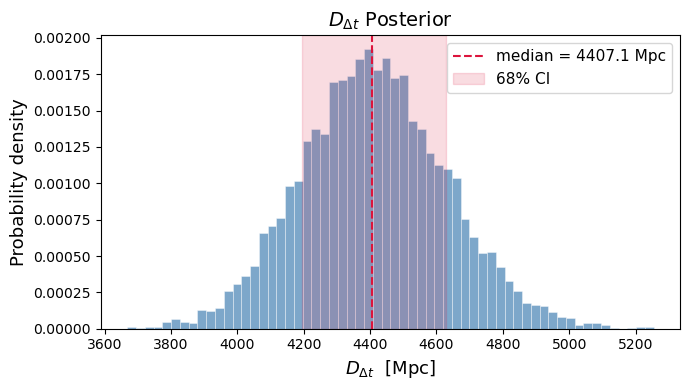

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(ddt_samples, bins=60, density=True, alpha=0.7, color="steelblue",
        edgecolor="white", linewidth=0.4)
ax.axvline(ddt_median, color="crimson", ls="--", lw=1.5, label=f"median = {ddt_median:.1f} Mpc")
ax.axvspan(ddt_lo, ddt_hi, alpha=0.15, color="crimson", label="68% CI")
ax.set_xlabel(r"$D_{\Delta t}$  [Mpc]", fontsize=13)
ax.set_ylabel("Probability density", fontsize=13)
ax.set_title(r"$D_{\Delta t}$ Posterior", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## H_0 Posterior

Convert each $D_{\Delta t}$ sample to $H_0$ via
$$
H_0 = \frac{c\,A(z_l, z_s, \Omega_M, \Omega_\Lambda)}{D_{\Delta t}}
$$
using `alpaca.utils.cosmology.Ddt_2_H0`.

In [9]:
h0_samples = np.array([
    Ddt_2_H0(ddt, Z_LENS, Z_SOURCE, OMEGA_M, OMEGA_L)
    for ddt in ddt_samples
])

h0_median = np.median(h0_samples)
h0_lo, h0_hi = np.percentile(h0_samples, [16, 84])

print(f"H_0 = {h0_median:.2f}  (+{h0_hi - h0_median:.2f} / -{h0_median - h0_lo:.2f})  km/s/Mpc  [median +/- 1sigma]")
print(f"      (assuming z_lens={Z_LENS}, z_source={Z_SOURCE}, "
      f"Omega_M={OMEGA_M}, Omega_L={OMEGA_L})")

H_0 = 46.42  (+2.34 / -2.23)  km/s/Mpc  [median +/- 1sigma]
      (assuming z_lens=0.529, z_source=2.81, Omega_M=0.3, Omega_L=0.7)


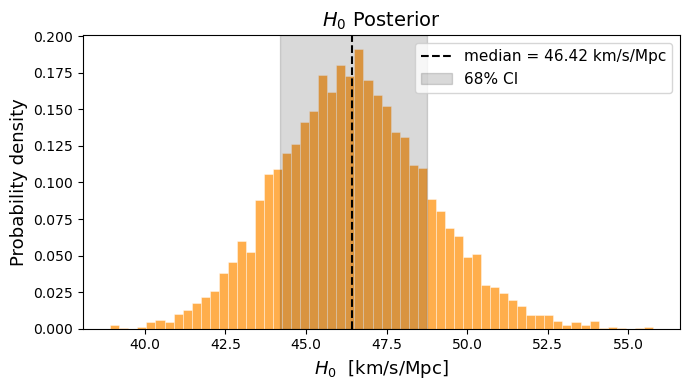

In [10]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(h0_samples, bins=60, density=True, alpha=0.7, color="darkorange",
        edgecolor="white", linewidth=0.4)
ax.axvline(h0_median, color="black", ls="--", lw=1.5,
           label=f"median = {h0_median:.2f} km/s/Mpc")
ax.axvspan(h0_lo, h0_hi, alpha=0.15, color="black", label="68% CI")
ax.set_xlabel(r"$H_0$  [km/s/Mpc]", fontsize=13)
ax.set_ylabel("Probability density", fontsize=13)
ax.set_title(r"$H_0$ Posterior", fontsize=14)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

## Side-by-Side Summary

Saved to ../results/run_2026-01-27_17-02/ddt_h0_posterior.png


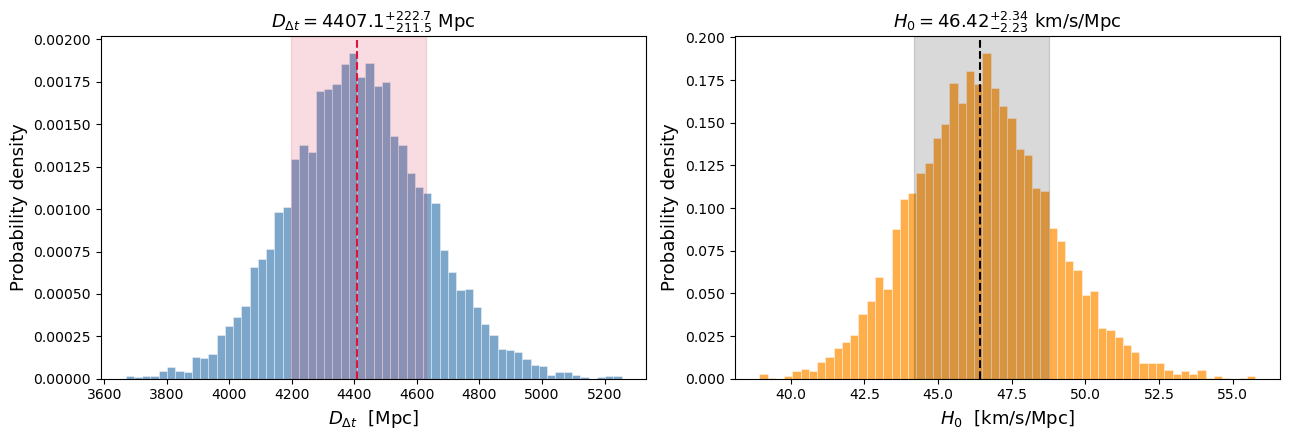

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

# D_dt
ax1.hist(ddt_samples, bins=60, density=True, alpha=0.7, color="steelblue",
         edgecolor="white", linewidth=0.4)
ax1.axvline(ddt_median, color="crimson", ls="--", lw=1.5)
ax1.axvspan(ddt_lo, ddt_hi, alpha=0.15, color="crimson")
ax1.set_xlabel(r"$D_{\Delta t}$  [Mpc]", fontsize=13)
ax1.set_ylabel("Probability density", fontsize=13)
ax1.set_title(
    rf"$D_{{\Delta t}} = {ddt_median:.1f}^{{+{ddt_hi-ddt_median:.1f}}}_{{-{ddt_median-ddt_lo:.1f}}}$ Mpc",
    fontsize=13,
)

# H_0
ax2.hist(h0_samples, bins=60, density=True, alpha=0.7, color="darkorange",
         edgecolor="white", linewidth=0.4)
ax2.axvline(h0_median, color="black", ls="--", lw=1.5)
ax2.axvspan(h0_lo, h0_hi, alpha=0.15, color="black")
ax2.set_xlabel(r"$H_0$  [km/s/Mpc]", fontsize=13)
ax2.set_ylabel("Probability density", fontsize=13)
ax2.set_title(
    rf"$H_0 = {h0_median:.2f}^{{+{h0_hi-h0_median:.2f}}}_{{-{h0_median-h0_lo:.2f}}}$ km/s/Mpc",
    fontsize=13,
)

plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, "ddt_h0_posterior.png"), dpi=200, bbox_inches="tight")
print(f"Saved to {os.path.join(RUN_DIR, 'ddt_h0_posterior.png')}")
plt.show()